In [8]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/shwetank/code/makemore-utils-nbs')
import torch
import tiktoken

In [9]:
# hyperparameters
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
batch_size = 32
block_size = 128
max_iters = 100
eval_iters = 10
eval_interval = 10
learning_rate = 1e-3
emb_dim = 384
num_heads = 6
num_layers = 6
dropout = 0.2
linear_scaleup = 4
temperature = 1


In [10]:
with open('./train.txt', 'r') as f:
    train_data_words = f.read()

with open('./test.txt', 'r') as f:
    test_data_words = f.read()

In [11]:
tokenizer = tiktoken.get_encoding("cl100k_base")
# assert enc.decode(enc.encode("hello world")) == "hello world"

In [5]:
train_tokens = tokenizer.encode(train_data_words)
test_tokens = tokenizer.encode(test_data_words)
# tokenizer.decode(training_tokens[:10])

In [6]:
train_tensor = torch.tensor(train_tokens, dtype=torch.long)
test_tensor = torch.tensor(test_tokens, dtype=torch.long)

In [7]:
from torch.utils.data import Dataset
import torch

class WikiData(Dataset):
    def __init__(self, dataset: Dataset, block_size: int=256, batch_size: int=1):
        self.block_size = block_size
        self.batch_size = batch_size
        self.dataset = dataset
        

    def __len__(self) -> int:
        return self.block_size

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        x = torch.zeros((self.batch_size,self.block_size + 1), dtype=torch.long)
        y = torch.zeros((self.batch_size,self.block_size + 1), dtype=torch.long)
        # print(idx)
        x = self.dataset[idx:idx+self.block_size]
        y = self.dataset[idx+1:idx+self.block_size+1]
        return x.to(device), y.to(device)
            

In [8]:
## Get batches from training and test data
train_data_obj = WikiData(train_tensor, block_size=block_size)
test_data_obj = WikiData(train_tensor, block_size=block_size)

In [9]:
tokenizer.n_vocab

100277

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Feedforward(nn.Module):
    def __init__(self,emb_dim,dropout) -> None:
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, linear_scaleup * emb_dim),
            nn.ReLU(),
            nn.Linear(linear_scaleup * emb_dim, emb_dim),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        return self.ff(x)

class Block(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout) -> None:
        super().__init__()
        self.head_size = emb_dim // num_heads
        self.sa_head = nn.MultiheadAttention(emb_dim, num_heads, dropout)
        self.ff = Feedforward(emb_dim, dropout)
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)

    def forward(self, x, targets=None):
        x = self.ln1(x)
        sa_out, _ = self.sa_head(x,x,x)
        x = x + sa_out
        x = x + self.ff(self.ln2(x))
        return x


class Xformer(nn.Module):
    def __init__(self, emb_dim, num_heads, dropout): #num_layers = 3 --> needs to be properl parametrized
        super().__init__()
        self.tok_emb = nn.Embedding(tokenizer.n_vocab, emb_dim)
        self.pos_emb = nn.Embedding(tokenizer.n_vocab, emb_dim)
        self.blocks = nn.Sequential(
            Block(emb_dim, num_heads, dropout), 
            Block(emb_dim, num_heads, dropout),
            Block(emb_dim, num_heads, dropout),
            Block(emb_dim, num_heads, dropout), 
            Block(emb_dim, num_heads, dropout),
            Block(emb_dim, num_heads, dropout),
            nn.LayerNorm(emb_dim)
        ) 
        self.lm_head = nn.Linear(emb_dim, tokenizer.n_vocab)

    def forward(self, x, targets=None):
        x = self.tok_emb(x) + self.pos_emb(x)
        x = self.blocks(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            # print(logits.view(-1, logits.size(-1)).shape, targets.view(-1).shape)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return(logits,loss)

In [11]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_data_obj, batch_size=1)
test_dataloader = DataLoader(test_data_obj, batch_size=1)

In [12]:
# Single test run
from torch.optim import Adam
xb, yb = next(iter(train_dataloader))
model = Xformer(emb_dim, num_heads, dropout).to(device)
optimizer = Adam(model.parameters(), lr=0.001)
logits, loss = model(xb,yb)
print(loss)


tensor(11.6163, device='mps:0', grad_fn=<NllLossBackward0>)


In [13]:
from utils import get_model_size
get_model_size(model)

126266933

In [14]:
# # ## Optimal lr sweep
# from utils import get_lr_loss
# import matplotlib.pyplot as plt
# num_epochs = 100
# lri, lossi =  get_lr_loss(model, optimizer, train_dataloader, num_epochs, device, -2, -1)
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

In [15]:
train_dataloader = DataLoader(train_data_obj, batch_size=batch_size)
test_dataloader = DataLoader(test_data_obj, batch_size=batch_size)
tr_loss = []
te_loss = []

In [30]:
from utils import evaluate_loss
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = max_iters
for steps in range(n_epochs):
    xb, yb = next(iter(train_dataloader))
    xb = xb.to(device)
    yb = yb.to(device)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, te_lossi = evaluate_loss(model, train_dataloader, test_dataloader, device, num_batches=10)
    tr_loss.append(tr_lossi)
    te_loss.append(te_lossi)
    # print(loss.item())

    if steps % eval_interval-1 == 0:
        print('ltr: ', tr_lossi, 'lte: ', te_lossi, 'single shot loss:', loss.item())

ltr:  4.26521635055542 lte:  4.26521635055542 single shot loss: 4.266134262084961
ltr:  4.2611613273620605 lte:  4.2611613273620605 single shot loss: 4.26219367980957
ltr:  4.260254383087158 lte:  4.260254383087158 single shot loss: 4.260554790496826
ltr:  4.260027885437012 lte:  4.260027885437012 single shot loss: 4.26073694229126
ltr:  4.259910583496094 lte:  4.259910583496094 single shot loss: 4.259404182434082
ltr:  4.259902477264404 lte:  4.259902477264404 single shot loss: 4.260210037231445
ltr:  4.2598185539245605 lte:  4.2598185539245605 single shot loss: 4.261122226715088
ltr:  4.259795665740967 lte:  4.259795665740967 single shot loss: 4.260348320007324
ltr:  4.259788990020752 lte:  4.259788990020752 single shot loss: 4.260289192199707
ltr:  4.2597880363464355 lte:  4.2597880363464355 single shot loss: 4.260014533996582


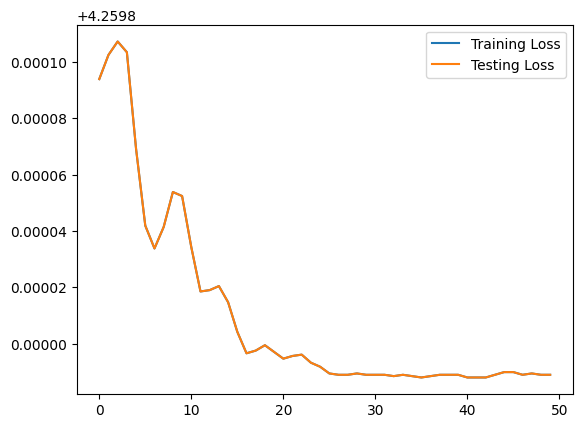

training loss:  4.2598
validation loss:  4.2598


In [35]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss[-50:], label='Training Loss')
plt.plot(te_loss[-50:], label='Testing Loss')
plt.legend()
plt.show()
print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-10:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(te_loss[-10:]))).item(),4))

In [14]:
@torch.no_grad()
def generate(model, max_new_tokens=block_size, batch_size=batch_size, temperature=temperature):
    idx = torch.zeros((batch_size, 1), dtype=torch.long).to(device)
    for _ in range(max_new_tokens):
        # print('idx shape:',idx.shape)
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        idx_cond = idx_cond.to(device)
        logits, _ = model(idx_cond)
        # Pick only the logits from most recent time step. Karpathy also does a divide by temp?
        # This is just Platt scaling which makes the various Softmax curves closes adding more randomness
        # see scratch.ipynb. https://en.wikipedia.org/wiki/Platt_scaling
        logits = logits[:,-1,:]/temperature
        probs = F.softmax(logits, dim=-1)
        # print('prob dist:',probs)
        idx_next = torch.multinomial(probs, num_samples=1)
        # print('idx_next shape:',idx_next.shape)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

    

In [37]:
X_samp = generate(model, block_size, 1, temperature).tolist()

In [38]:
for row in X_samp:
    print(tokenizer.decode(row))

! , before finish . in season full – was ran difference .201 goal finish League in the14 Football season eight seasonation North York , . ination the  in place  played of – season4 in second football June it his4thing competitive only club only3 York-4 season in – the York only –th77 manager club seasonth second the football ,th in  only year , eight = made Yorkshire  201 place City of summer@ starting signings in 
 in14 The – and  the  season made second17 above30 Leagueton signings turn summer  . ,4303  = . signings201 Nigel based Wor


In [39]:
# Specify the file path where you want to save the model weights
file_path = 'model_weights.pth'

# Save the model weights
torch.save(model.state_dict(), file_path)

In [15]:
import torch
model = Xformer(emb_dim, num_heads, dropout).to(device)
# Load the saved model weights
file_path = 'model_weights.pth'
model.load_state_dict(torch.load(file_path))
X_samp = generate(model, block_size, 1, temperature).tolist()
for row in X_samp:
    print(tokenizer.decode(row))

!  – finish competitive York full place201  Yorkshire club F1thing- the season season match their @ were Club football Their Two  By England season place2011 in4  season13 by turn football ,   Two second Nigel finish England turn @ made The zone as England ,  permanent football full @ and was the zone in association in season releg his2ton association.C The F starting North- and made77 by @ football   summer competitive  ran in314 in201 a season finish Yorkthing201 ran . second  eight@ in his consecutive eight League football competitive The as Football second the  2th . season
